In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import os
from qutip import Qobj
import qutip as qu
from tqdm import tqdm

from src.utilities import Matrix

from src.observables import entropy_vn, covariance_invariants, symplectic_eigenvalues, symplectic_eigenvalues_transposed, symplectic_entropy, mutual_information, gaussian_quantum_discord, logarithmic_negativity

D = 10
TIMEDELTA = 1
SUFFIX = '.npy'

In [2]:
# Files utilities

def file_dims(filename):
    return int(filename.split('_')[-3][1:])


def file_time(filename):
    return int(filename.split('_')[-2][1:])


def file_timedelta(filename):
    return float(filename.split('_')[-1][2:])


def check_file_metadata(filename):
    dims = file_dims(filename)
    timedelta = file_timedelta(filename)
    return dims == D and timedelta == TIMEDELTA


def get_all_files(state, observable):
    files = [file for file in os.listdir(f'../objects/{state}') if file.endswith(SUFFIX) and file.startswith(f'rho_{observable}')]
    return files

def get_cov_of_dims(dims, state) -> dict:
    files = {file_timedelta(file.removesuffix('.npy')): file for file in os.listdir(f'../objects/{state}') if file.endswith(SUFFIX) and file.startswith(f'rho_covariance_D{dims}')}
    return dict(sorted(files.items()))

def load(times, evolution_list):
    for t in tqdm(times):
        if SUFFIX=='.npz':
            try:
                rho_evolution_zip = np.load(f'../objects/rho_evolution_d{D}_t{t}_dt{TIMEDELTA}' + SUFFIX)
                rho_evolution_t = [rho_evolution_zip[t] for t in rho_evolution_zip.files]
                evolution_list.extend(rho_evolution_t)
                print(len(evolution_list))
            except MemoryError as e:
                print(e)
            break
        elif SUFFIX == '.npy':
            try:
                evolution_list = np.load(f'../objects/rho_entropy_D{D}_t{t}_dt{TIMEDELTA}' + SUFFIX)
                #  purity_evolution = np.load(f'../objects/rho_<//D{D}_t{t}_dt{TIMEDELTA}' + SUFFIX)
            except FileNotFoundError as e:
                print(e)

In [3]:
# Plotting functions

def plateau(values: np.ndarray):
    previous = np.roll(values, 1)
    previous[0] = 0
    threshold = 5e-3
    return np.abs(values - previous) < threshold


def find_plateau_start(arr: np.ndarray):
    little_entropy_change = plateau(arr[0:200])
    if sum(little_entropy_change) > 0:
        first_plateau = arr[little_entropy_change][0]
    else:
        # All is false, there is no plateau
        first_plateau = arr[-1]
    return np.where(arr == first_plateau)[0][0]


def plot_all_observables(file_list, state, observable):
    cut = 200  # Plot only this much data
    for file in file_list:
        obs_evolution = np.load(f'../objects/{state}/' + file)[:cut]
        d = file_dims(file)
        title = f'{d}-dimensions {observable} evolution'
        plot_observation(obs_evolution, title)

def highlight_features(ax, series):
    first_max = find_plateau_start(series)
    max_val = np.round(np.max(series), 3)
    ax.vlines(first_max, 0, max_val, ls='--', color='r')
    ax.hlines(max_val, 0, 120, ls='--', color='r')
    # Highlight the x-ticks of the plateau
    labels = [tick.get_text() for tick in ax.get_xticklabels()]
    locs=list(ax.get_xticks())
    labels+=[first_max]
    locs+=[first_max]
    ax.set_xticks(locs, labels)
    ax.get_xticklabels()[-1].set_color('red')
    ax.get_xticklabels()[-1].set_y(-0.03)
    # Highlight the y-tick of the maximum value
    labels = [tick.get_text() for tick in ax.get_yticklabels()]
    locs=list(ax.get_yticks())
    labels+=[max_val]
    locs+=[max_val]
    ax.set_yticks(locs, labels)
    ax.get_yticklabels()[-1].set_color('red')
    ax.get_yticklabels()[-1].set_x(-0.03)

def plot_observation(obs_evolution, title=None):
    fig, ax = plt.subplots()
    ax.plot(obs_evolution)
    ax = highlight_features(ax, obs_evolution)
    if title is not None:
        plt.title(title)
    return ax

def time(step, interaction_time):
    return step * interaction_time

## Coherent States Entropy Evolution

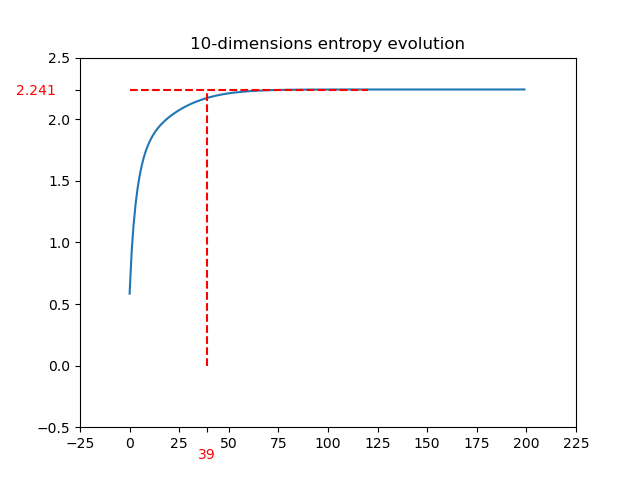

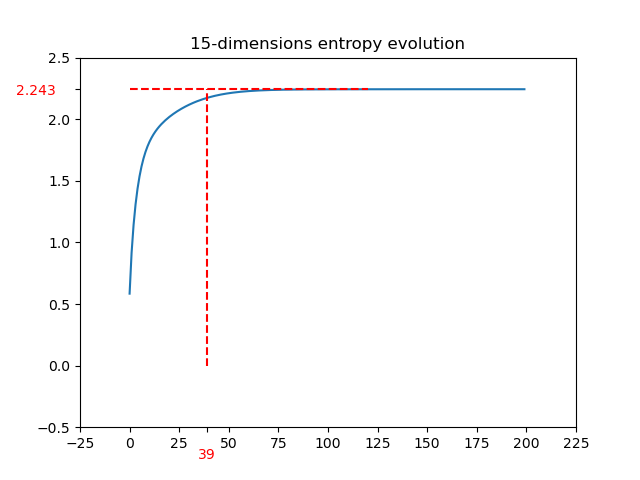

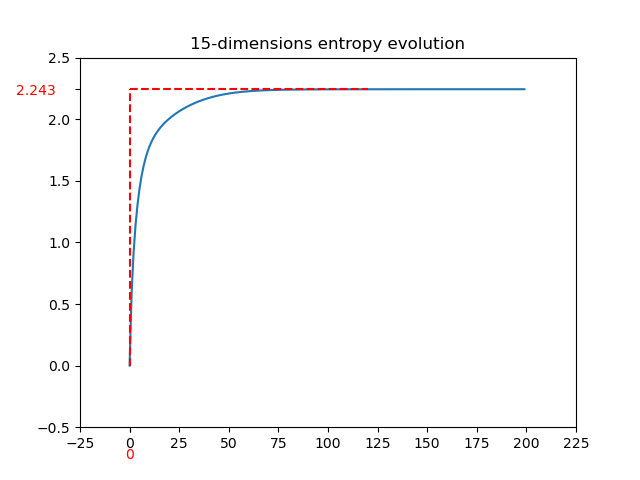

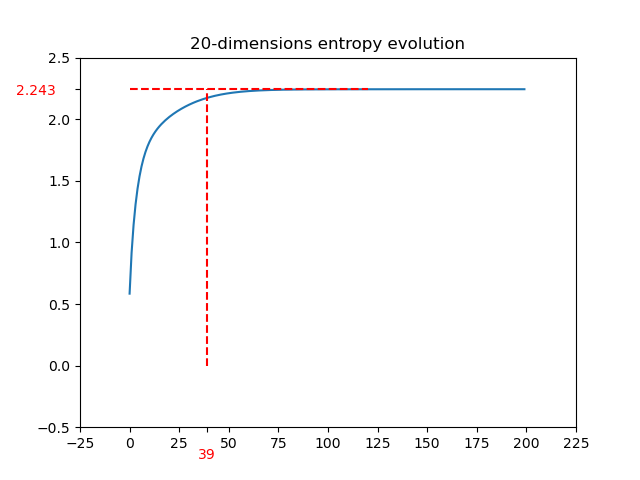

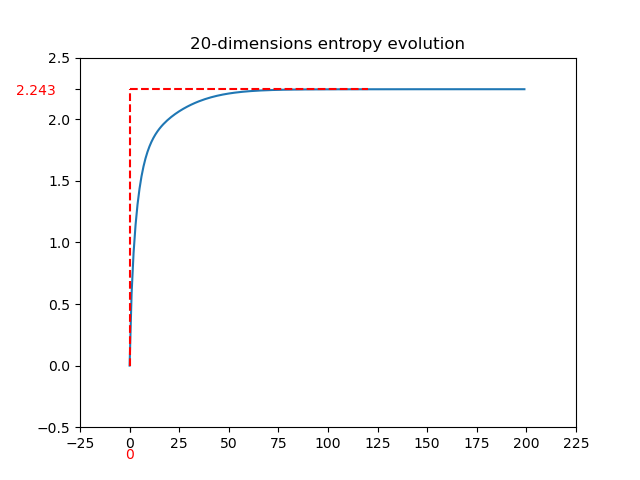

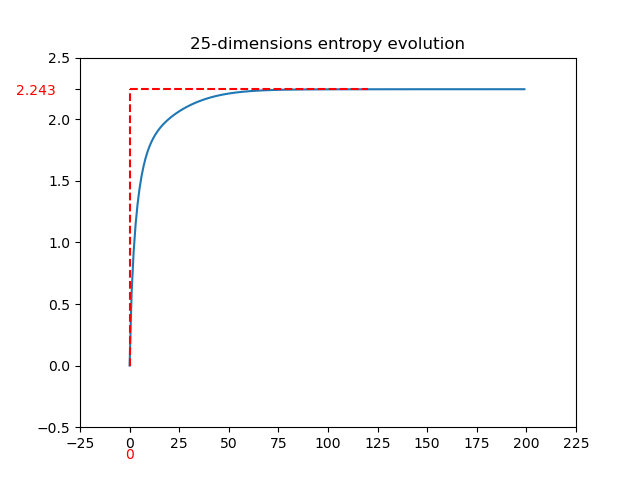

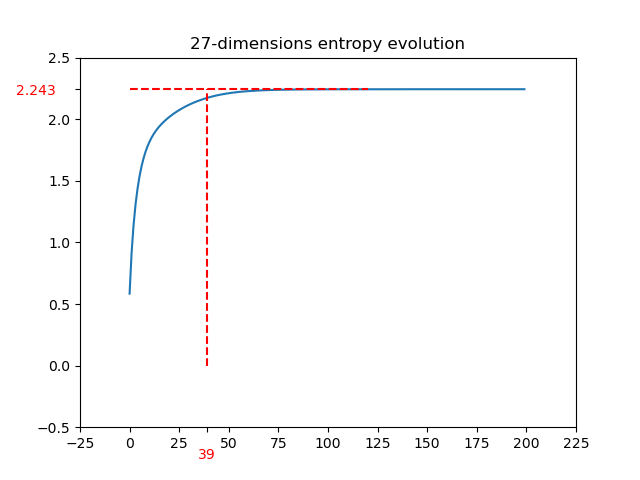

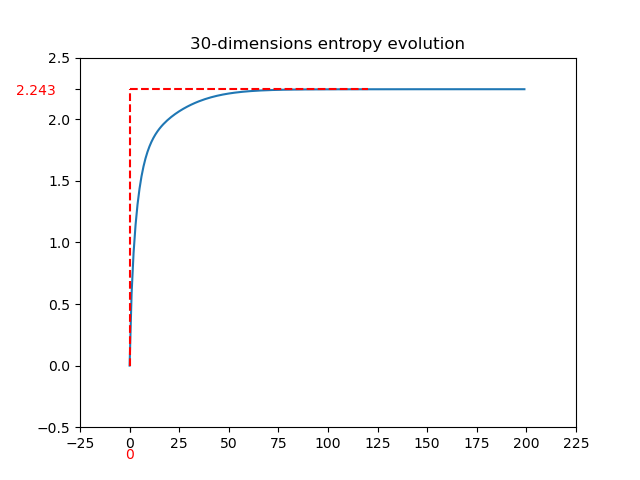

In [4]:
state = 'coherent'
observable = 'entropy'
entropy_files = get_all_files(state, observable)
plot_all_observables(entropy_files, state, observable)

### From Covariance Matrix

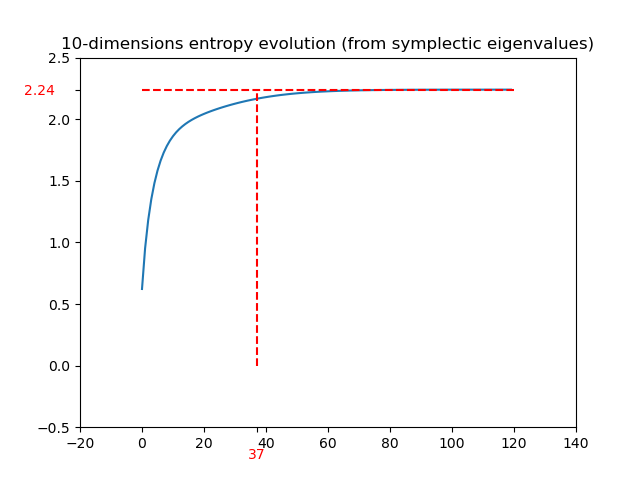

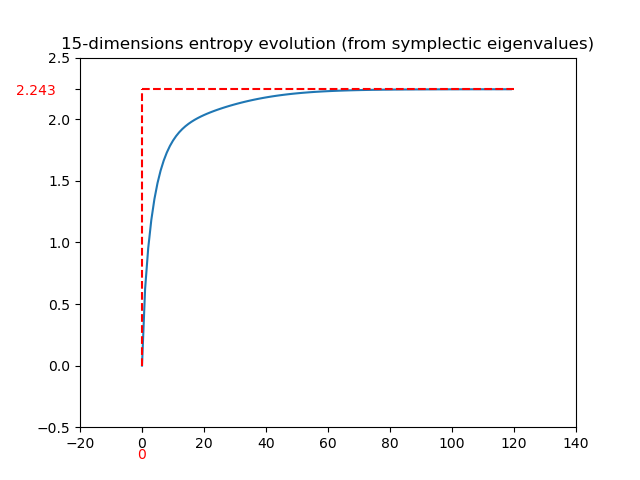

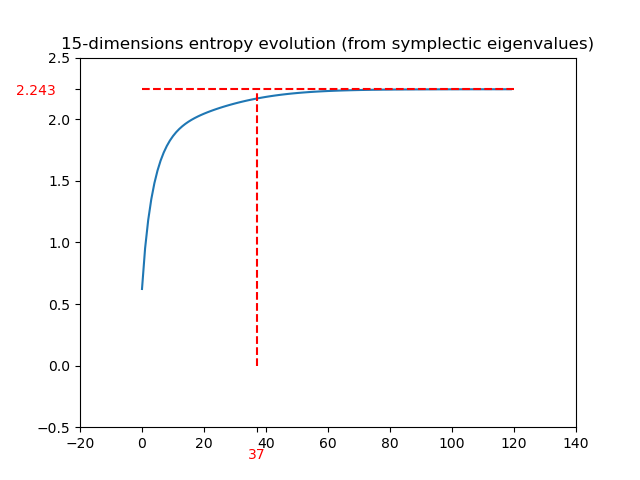

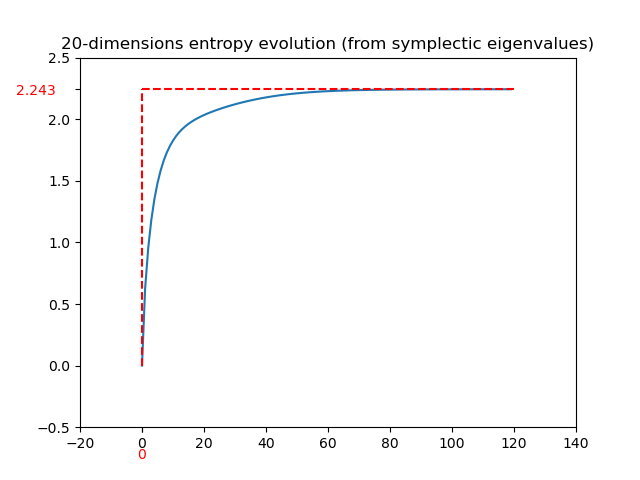

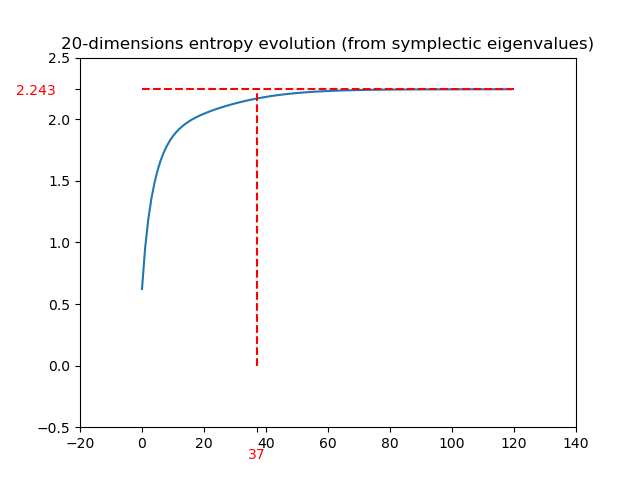

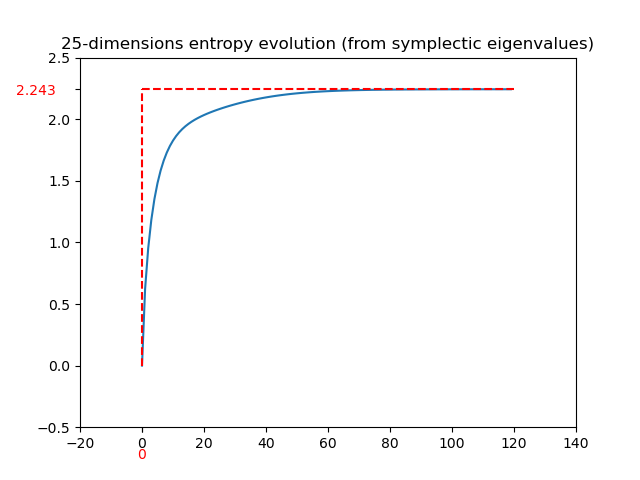

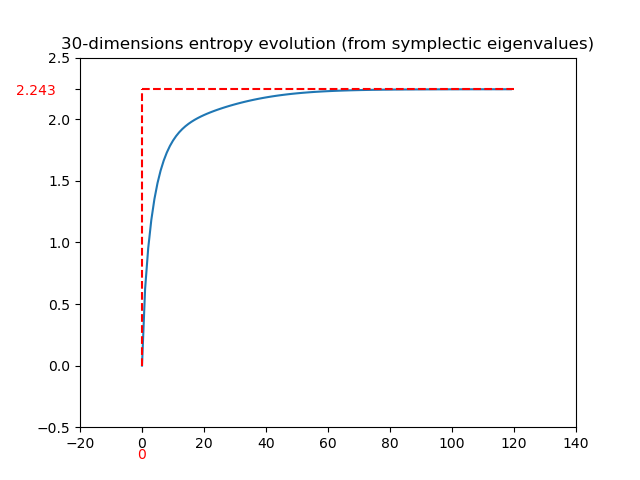

In [5]:
state = 'coherent'
observable = 'covariance'
cov_files = get_all_files(state, observable)
cut = 120
for file in cov_files:
    cov_evolution = np.load(f'../objects/{state}/' + file)[:cut]
    # Find symplectig eigenvalues from covariance invariants
    nus_evolution = np.array([symplectic_eigenvalues(cov) for cov in cov_evolution])
    entropy_evolution = np.array([symplectic_entropy(nus) for nus in nus_evolution])
    plot_title = f'{file_dims(file)}-dimensions entropy evolution (from symplectic eigenvalues)'
    ax = plot_observation(np.real(entropy_evolution), plot_title)

## Fock States Entropy Evolution

C:\Users\fedes\AppData\Local\Temp\ipykernel_8956\3358375924.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


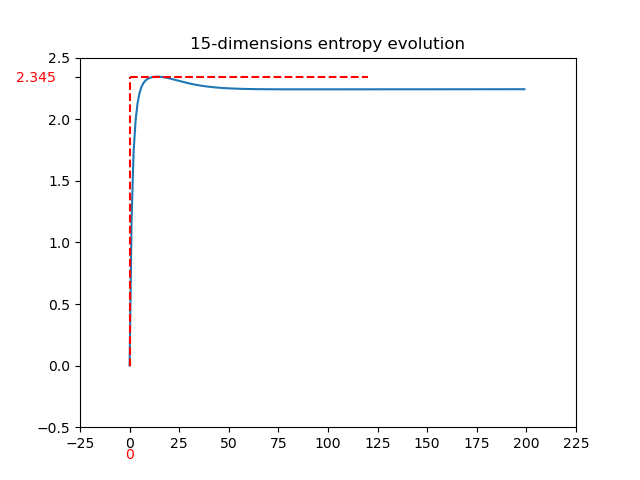

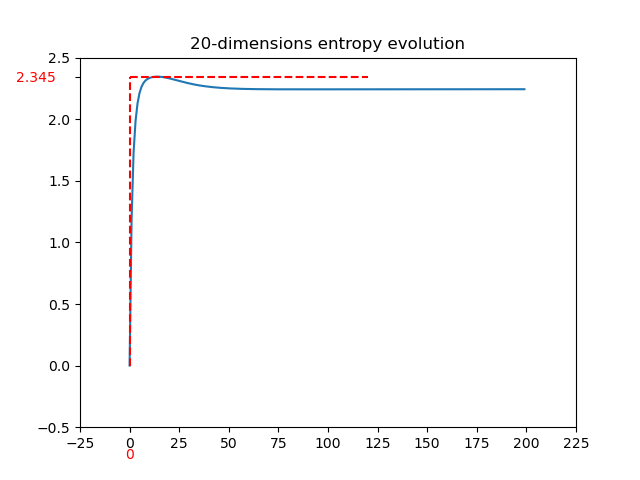

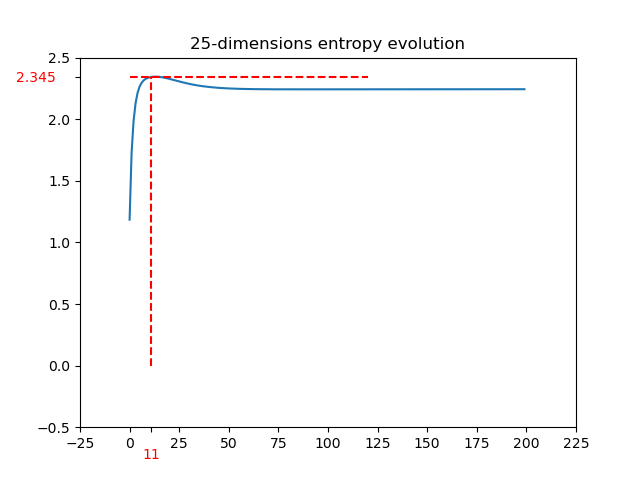

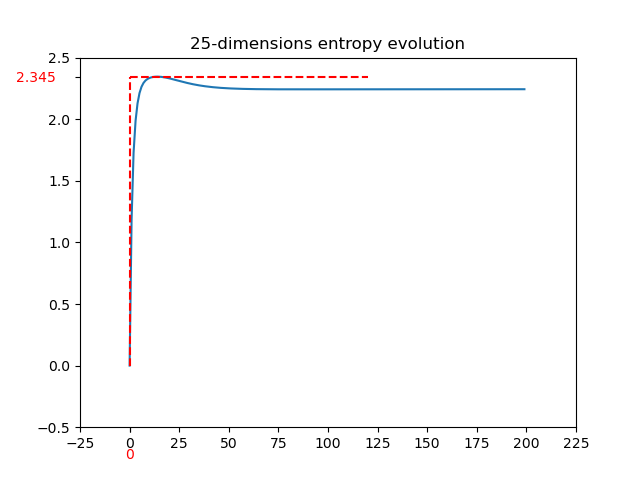

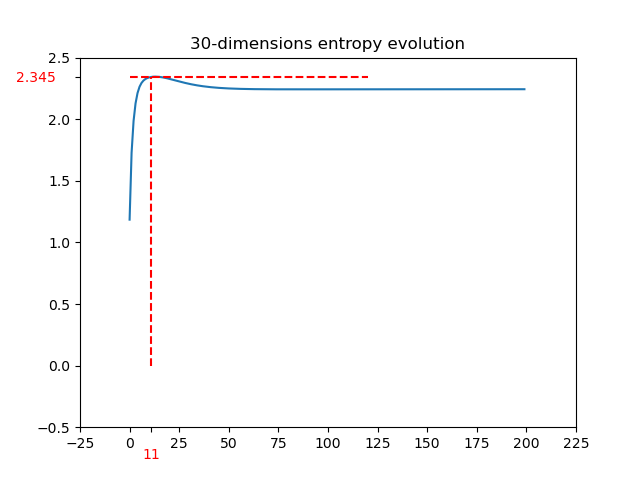

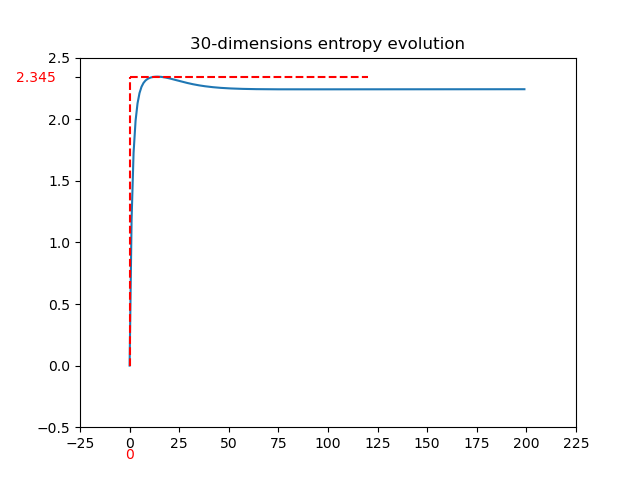

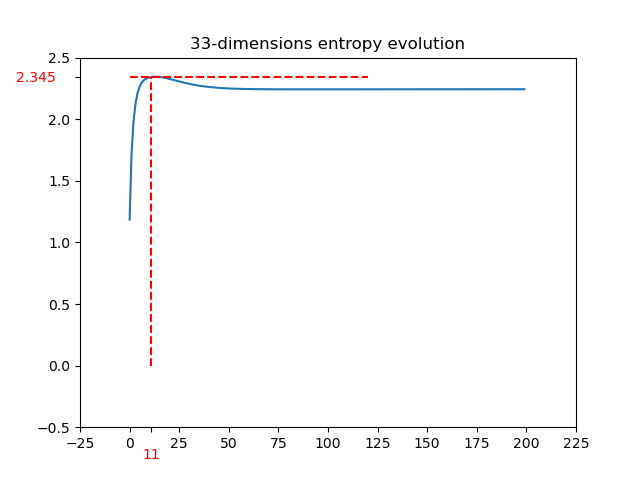

In [6]:
state = 'fock'
observable = 'entropy'
entropy_files = get_all_files(state, observable)
plot_all_observables(entropy_files, state, observable)

### From Covariance Matrix

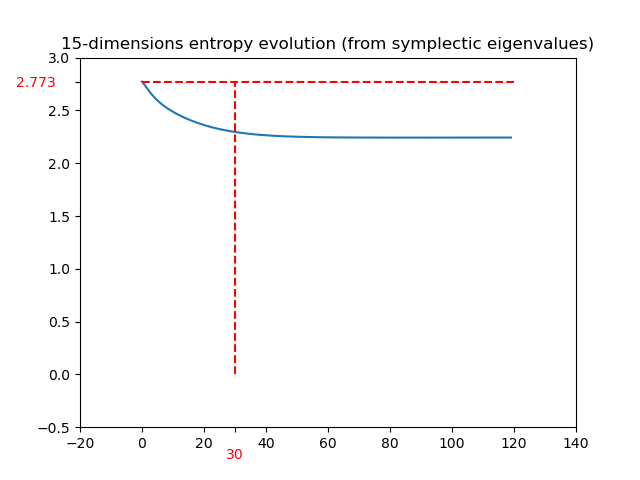

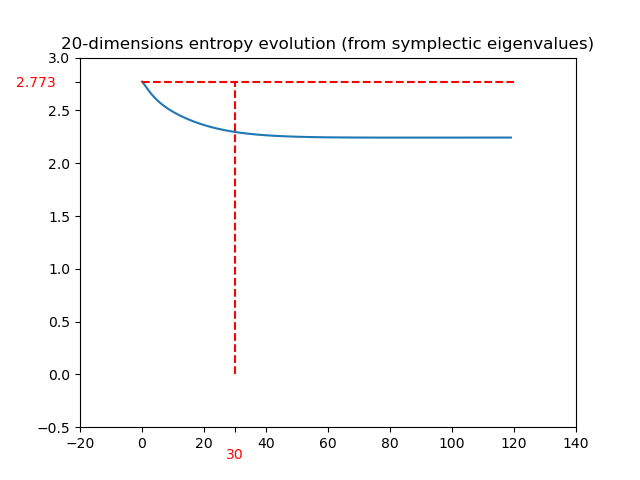

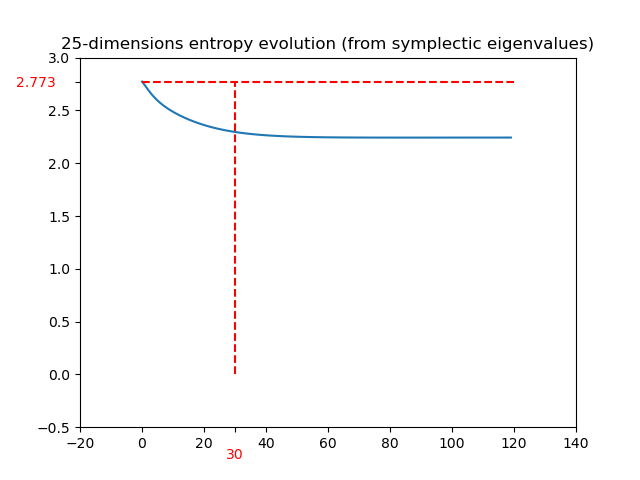

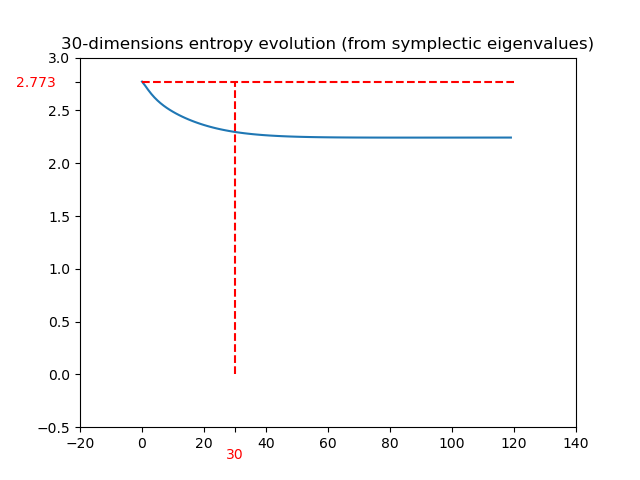

In [7]:
state = 'fock'
observable = 'covariance'
cov_files = get_all_files(state, observable)
cut = 120
for file in cov_files:
    cov_evolution = np.load(f'../objects/{state}/' + file)[:cut]
    # Find symplectig eigenvalues from covariance invariants
    nus_evolution = np.array([symplectic_eigenvalues(cov) for cov in cov_evolution])
    entropy_evolution = np.array([symplectic_entropy(nus) for nus in nus_evolution])
    plot_title = f'{file_dims(file)}-dimensions entropy evolution (from symplectic eigenvalues)'
    ax = plot_observation(np.real(entropy_evolution), plot_title)

## Thermal States Entropy Evolution

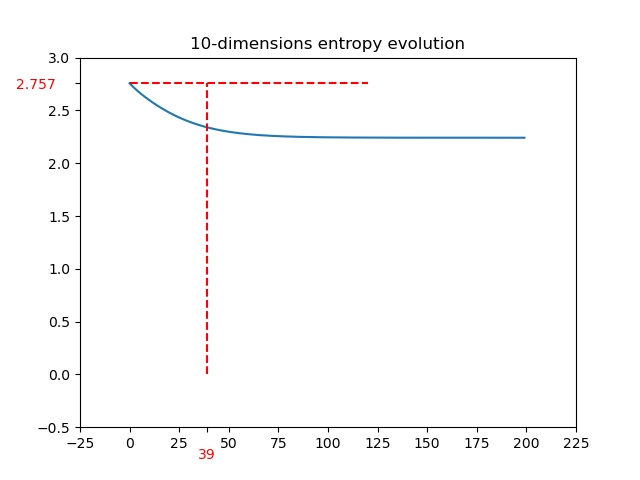

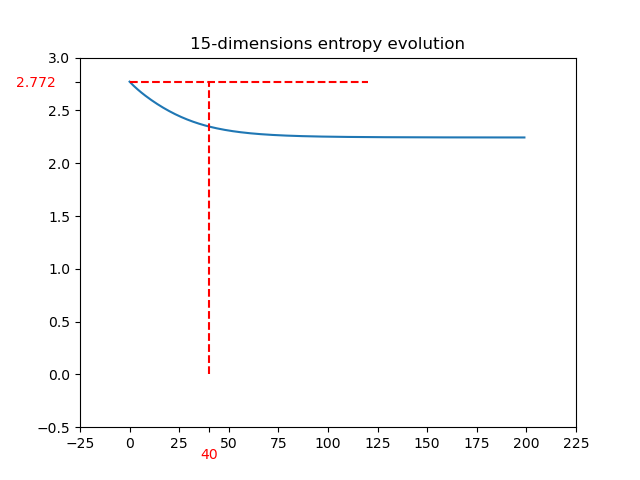

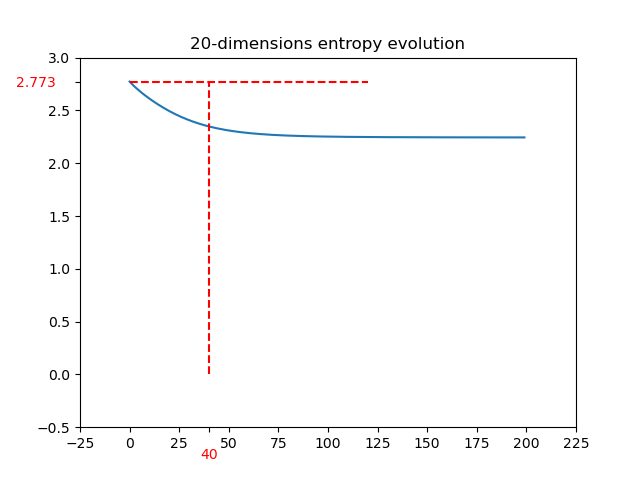

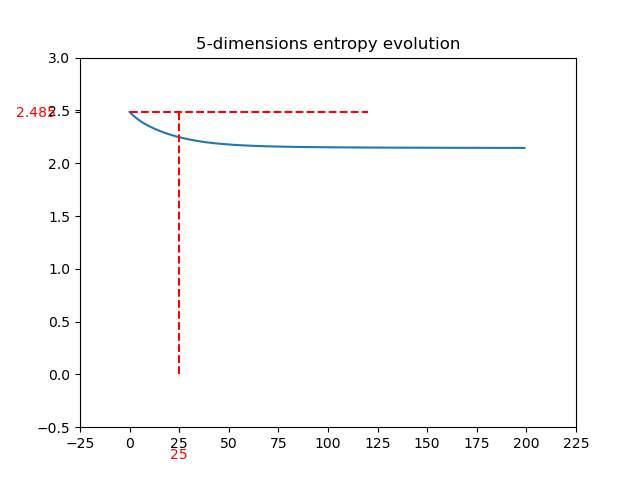

In [8]:
state = 'thermal'
observable = 'entropy'
entropy_files = get_all_files(state, observable)
plot_all_observables(entropy_files, state, observable)

### From Covariance Matrix

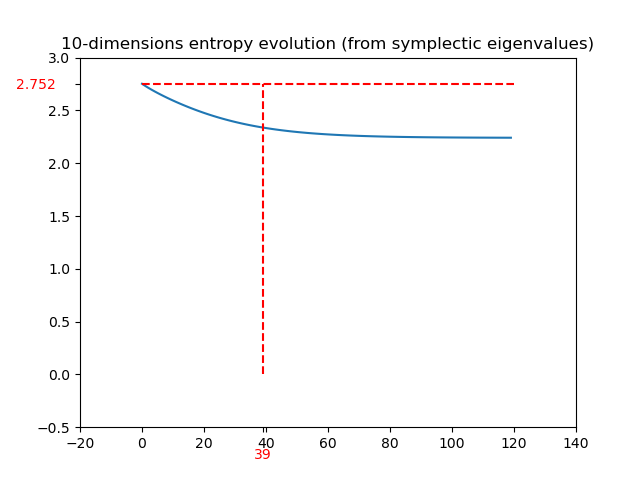

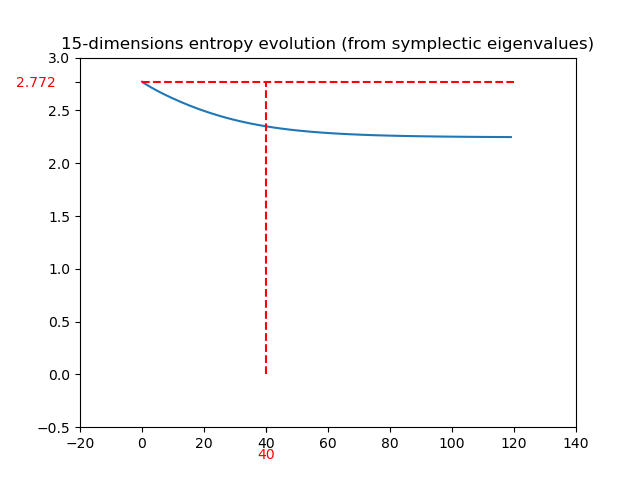

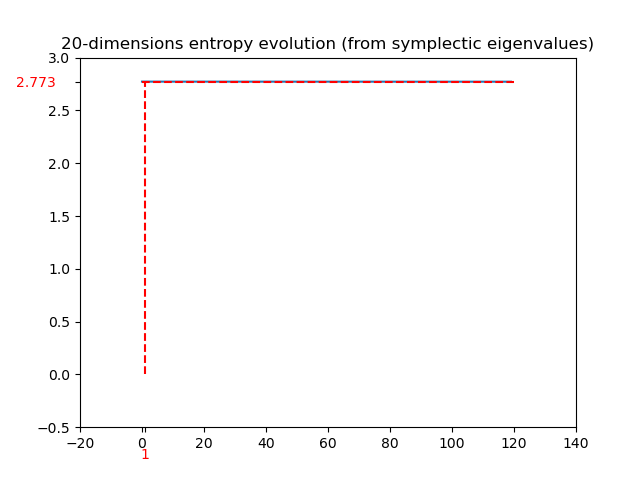

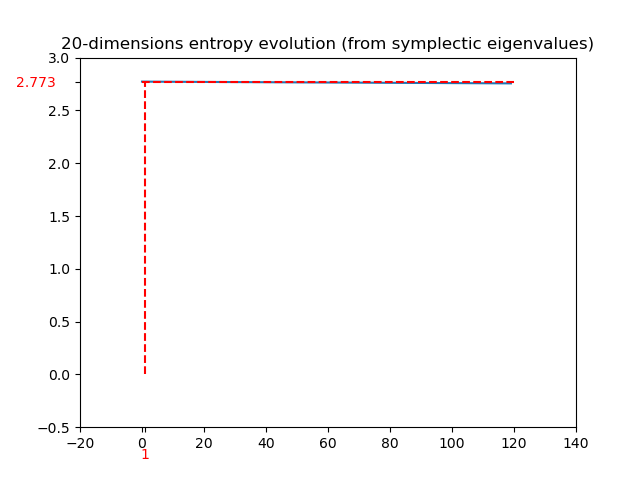

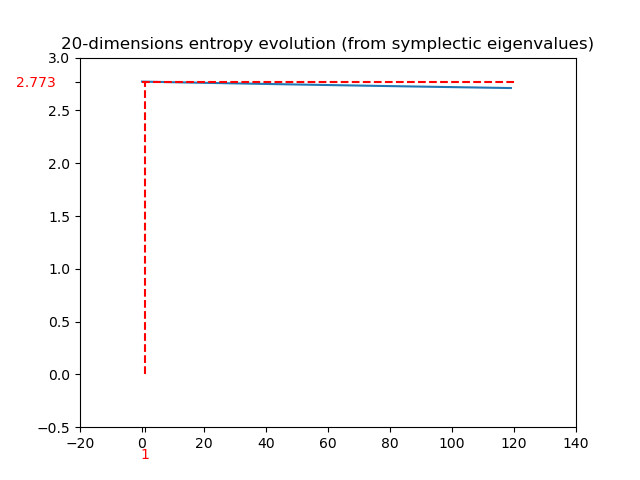

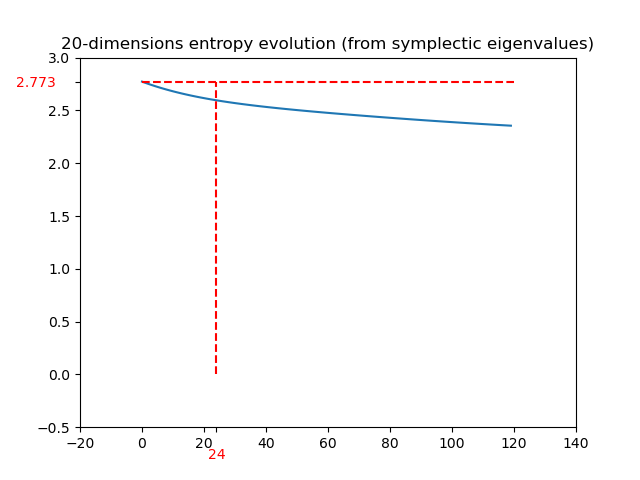

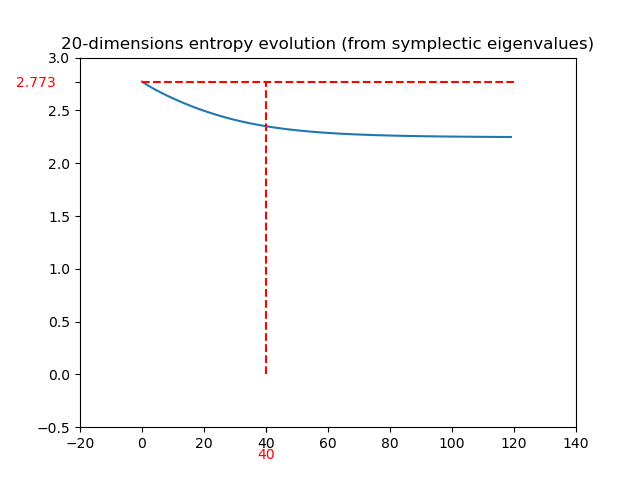

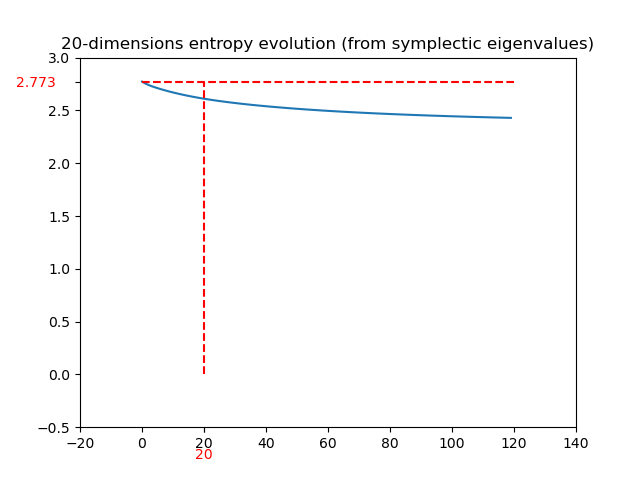

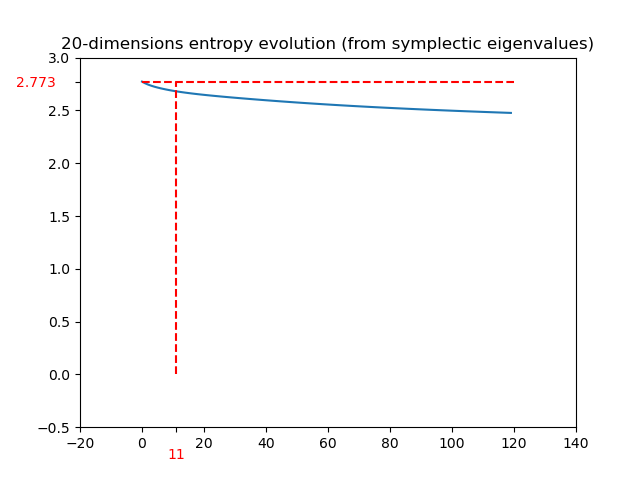

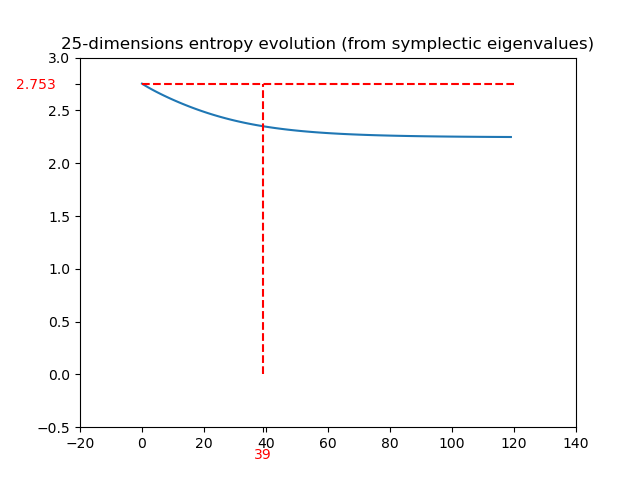

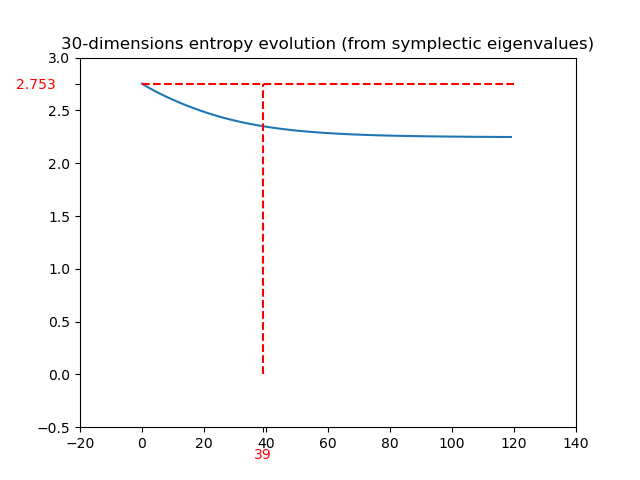

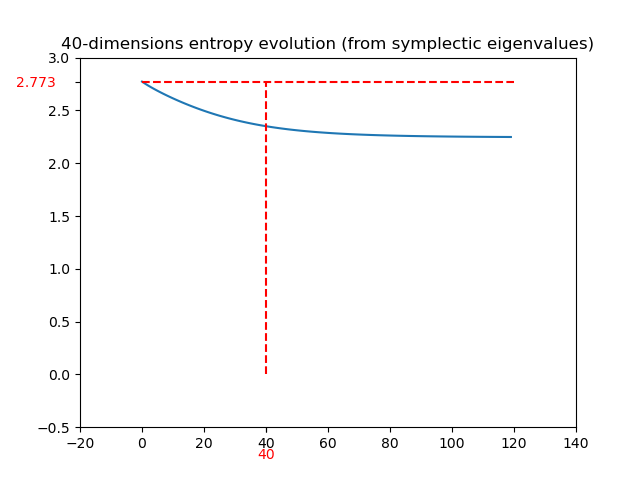

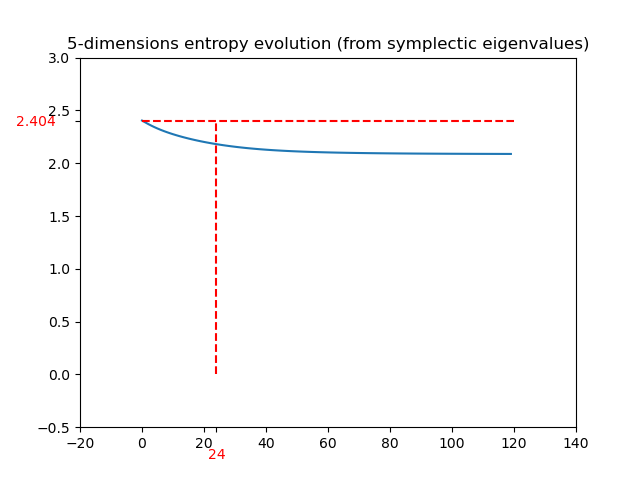

In [9]:
state = 'thermal'
observable = 'covariance'
cov_files = get_all_files(state, observable)
cut = 120
for file in cov_files:
    cov_evolution = np.load(f'../objects/{state}/' + file)[:cut]
    # Find symplectig eigenvalues from covariance invariants
    nus_evolution = np.array([symplectic_eigenvalues(cov) for cov in cov_evolution])
    entropy_evolution = np.array([symplectic_entropy(nus) for nus in nus_evolution])
    plot_title = f'{file_dims(file)}-dimensions entropy evolution (from symplectic eigenvalues)'
    ax = plot_observation(np.real(entropy_evolution), plot_title)

# Conclusion:
## Covariance Matrix suffice to describe the evolution of the system even for low dimensions (20)

# Effects of Interaction Time on the evolution

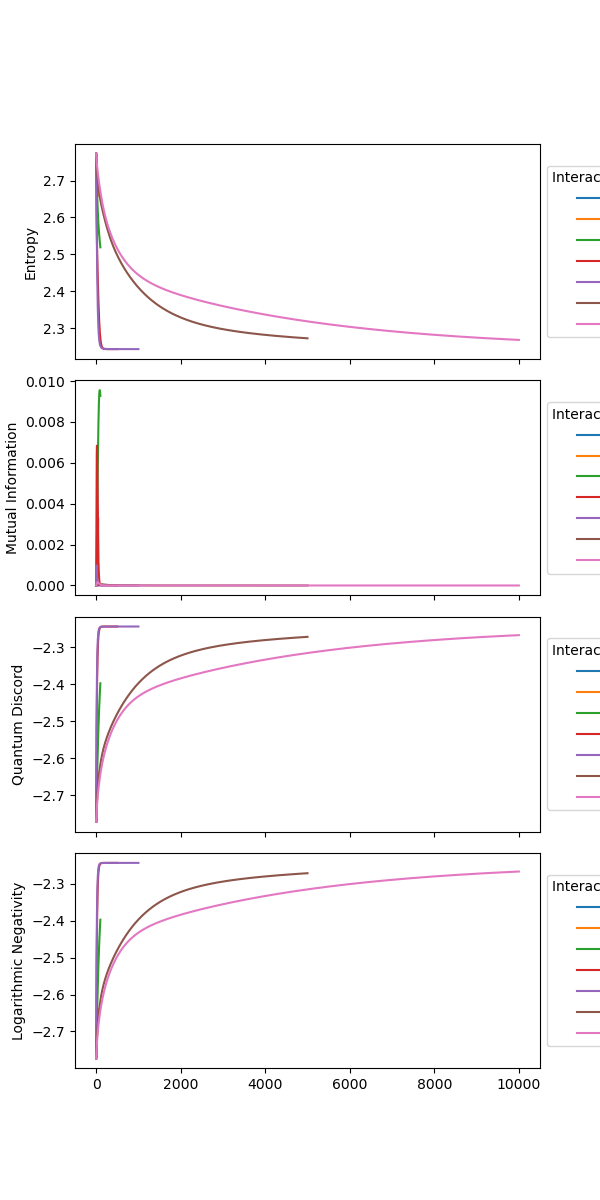

In [11]:
observables = ['Entropy', 'Mutual Information', 'Quantum Discord', 'Logarithmic Negativity']
fig, axs = plt.subplots(len(observables), 1, figsize=(6, 12), sharex='all')
state = 'thermal'
cov_files = get_cov_of_dims(20, state)
for timedelta, file in cov_files.items():
    cov_evolution = np.load(f'../objects/{state}/' + file)
    time = [i * timedelta for i in range(len(cov_evolution))]
    # Find symplectic eigenvalues from covariance invariants
    nus_evolution = [symplectic_eigenvalues(cov) for cov in cov_evolution]
    entropy_evolution = [symplectic_entropy(cov) for cov in cov_evolution]
    mut_inf_evolution = [mutual_information(cov) for cov in cov_evolution]
    discord_evolution = [gaussian_quantum_discord(cov) for cov in cov_evolution]
    logneg_evolution = [logarithmic_negativity(cov) for cov in cov_evolution]
    axs[0].plot(time, entropy_evolution, label=f'{timedelta}')
    axs[1].plot(time, mut_inf_evolution, label=f'{timedelta}')
    axs[2].plot(time, discord_evolution, label=f'{timedelta}')
    axs[3].plot(time, discord_evolution, label=f'{timedelta}')
plt.subplots_adjust(hspace=0.1)
# Title each subplot
for i, title in enumerate(observables):
    axs[i].set_ylabel(title)
# Put a legend to the right of the current axis
for i in range(len(observables)):
    axs[i].legend(title='Interaction times',
                  loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
